In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [20]:
def grad_U(Ui, Yij, Vj, ai, bj, reg, eta):
    error = Yij - (np.dot(Ui, Vj) + ai + bj)
    return eta * (error * Vj - reg * Ui)

def grad_V(Vj, Yij, Ui, ai, bj, reg, eta):
    error = Yij - (np.dot(Ui, Vj) + ai + bj)
    return eta * (error * Ui - reg * Vj)

def grad_a(Yij, Ui, Vj, ai, bj, reg, eta):
    error = Yij - (np.dot(Ui, Vj) + ai + bj)
    return eta * (error - reg * ai)

def grad_b(Yij, Ui, Vj, ai, bj, reg, eta):
    error = Yij - (np.dot(Ui, Vj) + ai + bj)
    return eta * (error - reg * bj)

def get_err(U, V, a, b, Y, reg=0.0):
    mse = 0.0
    for i, j, Yij in Y:
        i, j = int(i) - 1, int(j) - 1
        error = Yij - (np.dot(U[i], V[j]) + a[i] + b[j])
        mse += error ** 2
    mse /= 2
    reg_term = (reg / 2) * (np.linalg.norm(U) ** 2 + np.linalg.norm(V) ** 2)
    return (mse + reg_term) / Y.shape[0]

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    a = np.zeros(M)  # User biases
    b = np.zeros(N)  # Movie biases
    
    initial_loss = get_err(U, V, a, b, Y, reg)
    prev_loss = initial_loss
    
    for epoch in range(max_epochs):
        np.random.shuffle(Y)
        for i, j, Yij in Y:
            i, j = int(i) - 1, int(j) - 1
            
            U[i] += grad_U(U[i], Yij, V[j], a[i], b[j], reg, eta)
            V[j] += grad_V(V[j], Yij, U[i], a[i], b[j], reg, eta)
            a[i] += grad_a(Yij, U[i], V[j], a[i], b[j], reg, eta)
            b[j] += grad_b(Yij, U[i], V[j], a[i], b[j], reg, eta)
        
        loss = get_err(U, V, a, b, Y, reg)
        loss_delta = prev_loss - loss
        if epoch == 0:
            initial_reduction = loss_delta
        elif loss_delta / initial_reduction <= eps:
            print(epoch)
            break
        prev_loss = loss
    
    return U, V, a, b, get_err(U, V, a, b, Y, reg=0.0)


In [21]:
Y_train = pd.read_csv("train.csv").values
Y_test = pd.read_csv("test.csv").values

In [22]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int)
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int)

In [23]:
def train_and_evaluate(params):
    K, eta, reg, train_index, val_index = params
    
    train_set, val_set = Y_train[train_index], Y_train[val_index]

    U, V, a, b, e_in = train_model(M, N, 20, eta, reg, train_set)
    
    e_out = get_err(U, V, a, b, val_set)
    
    
    return (K, eta, reg, e_in, e_out)

In [24]:
from sklearn.model_selection import KFold
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

regs = [0.05, 0.1, 0.15, 0.2]
etas = np.geomspace(0.001, 0.1, 5)

kf = KFold(n_splits=5, shuffle=True)

tasks = []
for reg in regs:
    for eta in etas:
        for fold, (train_index, val_index) in enumerate(kf.split(Y_train)):
            tasks.append((20, eta, reg, train_index, val_index))

with Pool(28) as pool:
    results = list(tqdm(pool.imap(train_and_evaluate, tasks), total=len(tasks)))
    pool.close()
    pool.join()
    
E_ins = {}
E_outs = {}

for K, eta, reg, e_in, e_out in results:
    if (eta, reg) not in E_ins:
        E_ins[(eta, reg)] = []
        E_outs[(eta, reg)] = []
    E_ins[(eta, reg)].append(e_in)
    E_outs[(eta, reg)].append(e_out)

E_ins_avg = [(eta, reg, np.mean(E_ins[(eta, reg)])) for eta, reg, in E_ins]
E_outs_avg = [(eta, reg, np.mean(E_outs[(eta, reg)])) for eta, reg, in E_outs]

  0%|          | 0/100 [00:00<?, ?it/s]

6
8
8
9
13
18
22
21
22
25
50
50
55
57
58
37
42
16
18
50
5
24
15
8
7
34
21
7
38
11
93
96
107
102
120
123
124
120
124
114
14
12
18
26
12
27
6
14
2
2
2
4
33
67
17
67
36
71
75
69
23
14
21
14
22
53
61
62
63
9
10
7
2
3
66
2
9
4
4
12
267
190
266
270
283
287
205
200
202


  1%|          | 1/100 [13:08<21:40:51, 788.40s/it]

205


  2%|▏         | 2/100 [13:12<8:54:36, 327.31s/it] 

155


 76%|███████▌  | 76/100 [13:16<02:05,  5.22s/it]  

153
160
163


 76%|███████▌  | 76/100 [13:27<02:05,  5.22s/it]

173


100%|██████████| 100/100 [13:42<00:00,  8.22s/it]


In [25]:
E_outs_avg.sort(key=lambda x: x[2])

In [26]:
E_outs_avg

[(np.float64(0.01), 0.1, np.float64(0.43640303205783637)),
 (np.float64(0.0031622776601683794), 0.1, np.float64(0.43655592600282)),
 (np.float64(0.001), 0.1, np.float64(0.4389714438452832)),
 (np.float64(0.01), 0.15, np.float64(0.44656923211667393)),
 (np.float64(0.03162277660168379), 0.1, np.float64(0.44877555785928047)),
 (np.float64(0.03162277660168379), 0.15, np.float64(0.4513542127054615)),
 (np.float64(0.0031622776601683794), 0.15, np.float64(0.45181556143509194)),
 (np.float64(0.001), 0.15, np.float64(0.4553386596857944)),
 (np.float64(0.001), 0.05, np.float64(0.46814549994551324)),
 (np.float64(0.03162277660168379), 0.2, np.float64(0.4699028669076949)),
 (np.float64(0.0031622776601683794), 0.05, np.float64(0.47128252594186304)),
 (np.float64(0.0031622776601683794), 0.2, np.float64(0.4723684970555241)),
 (np.float64(0.01), 0.2, np.float64(0.4768829985999659)),
 (np.float64(0.01), 0.05, np.float64(0.4783706148016817)),
 (np.float64(0.001), 0.2, np.float64(0.48029249780854444)),
 

/tmp/ipykernel_77637/3541705566.py:10: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(f"{z:.3f}", (x, y), textcoords="offset points")


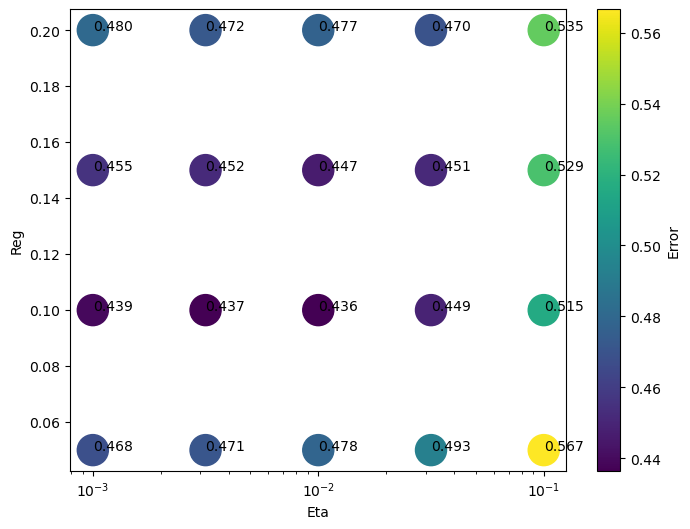

In [28]:
x_vals, y_vals, z_vals = zip(*E_outs_avg)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_vals, y_vals, c=z_vals, s=500)

cbar = plt.colorbar(scatter)
cbar.set_label('Error')

for x, y, z in zip(x_vals, y_vals, z_vals):
    plt.annotate(f"{z:.3f}", (x, y), textcoords="offset points")

plt.xlabel('Eta')
plt.xscale('log')
plt.ylabel('Reg')

# Show plot
plt.show()

In [29]:
U, V, a, b, e_in = train_model(M, N, 20, 0.01, 0.1, Y_train)

35


In [32]:
get_err(U, V, a, b, Y_test)

np.float64(0.4195994797280998)

In [33]:
np.save("scratch_bias", V)